In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import pylab as pl
import numpy as np

import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
file_name = "risk.xlsx"
df = pd.read_excel(file_name)
df.head() 

,id,age,gender,income,marit1,marit2,marit3,numkids,numcards,mortgage,howpaid,storecar,loans,risk
0,100001,25,0,28.085,0,0,1,0,1,1,0,1,0,1
1,100004,32,0,29.892,0,0,1,0,0,1,0,0,0,1
2,100005,25,1,25.991,0,0,1,0,0,1,0,2,0,1
3,100008,25,1,32.461,0,0,1,0,0,1,0,2,0,1
4,100011,25,1,27.457,0,0,1,0,1,1,0,2,0,1


In [3]:
target = "risk"
df.describe()

,id,age,gender,income,marit1,marit2,marit3,numkids,numcards,mortgage,howpaid,storecar,loans,risk
count,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
mean,102128.323469,37.325510,0.513265,29.056207,0.500000,0.292857,0.207143,1.608163,2.897959,0.814286,0.462245,2.807143,1.308163,0.429592
std,1510.967686,8.366915,0.500079,9.934525,0.500255,0.455306,0.405466,1.327610,2.035386,0.389074,0.498827,1.561981,1.027177,0.495271
min,100001.000000,18.000000,0.000000,15.045000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100514.000000,31.000000,0.000000,22.492000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,102735.000000,39.000000,1.000000,26.598500,0.500000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,3.000000,1.000000,0.000000
75%,103579.500000,44.000000,1.000000,33.492250,1.000000,1.000000,0.000000,3.000000,5.000000,1.000000,1.000000,4.000000,2.000000,1.000000
max,104117.000000,50.000000,1.000000,59.944000,1.000000,1.000000,1.000000,4.000000,6.000000,1.000000,1.000000,5.000000,3.000000,1.000000


In [4]:
df_model, df_reserved = train_test_split(df, test_size=0.1, random_state=42)
print ("Sample size dataset reserved for prediction: ", df_reserved.shape[0], "records")

Sample size dataset reserved for prediction:  98 records


In [6]:
y = df_model[target]

# cross validation (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(df_model, y, test_size=0.2)
print ("Sample size train dataset: ", X_train.shape)
print ("Sample size test dataset: ", X_test.shape)

Sample size train dataset:  (705, 14)
Sample size test dataset:  (177, 14)


In [7]:
# Stepwise function
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [8]:
# Removes it from the explanatory set (as well as id)
irrelevant_columns = ['id', target]
X_train2=X_train.drop(columns=irrelevant_columns)

for field in X_train2:
    if X_train2[field].isnull().any():
        X_train2=X_train2.drop(labels=[field], axis=1)
        
X_train2

,age,gender,income,marit1,marit2,marit3,numkids,numcards,mortgage,howpaid,storecar,loans
225,35,1,46.645,1,0,0,1,1,1,0,2,0
341,44,0,53.660,1,0,0,1,1,1,0,1,1
877,27,0,29.041,1,0,0,3,4,1,0,5,1
969,50,0,21.061,1,0,0,3,4,1,0,5,1
716,47,0,27.678,0,1,0,4,6,1,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
770,50,1,15.926,0,1,0,2,5,1,1,5,3
967,50,0,21.498,1,0,0,2,4,1,0,5,1
131,44,1,27.070,0,0,1,0,0,1,0,1,0
689,47,1,18.351,0,1,0,2,5,1,1,4,2


In [9]:
result = stepwise_selection(X_train2, y_train)
print('resulting features:')
print(result) # relevant variables
type(result)

Optimization terminated successfully.
         Current function value: 0.624749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683549
  

list

### We estimate the model only with selected features from Stepwise and we select them in the test dataset as well

In [10]:
# Adds selected features
X_train_stepwise=X_train2
for item in X_train2.columns:
    if item not in result:
        X_train_stepwise=X_train_stepwise.drop(labels=[item],axis=1) #removes the non relevant variables

X_train_stepwise

,income,marit2,numcards,howpaid,storecar,loans
225,46.645,0,1,0,2,0
341,53.660,0,1,0,1,1
877,29.041,0,4,0,5,1
969,21.061,0,4,0,5,1
716,27.678,1,6,1,3,2
...,...,...,...,...,...,...
770,15.926,1,5,1,5,3
967,21.498,0,4,0,5,1
131,27.070,0,0,0,1,0
689,18.351,1,5,1,4,2


In [11]:
X_test_stepwise = X_test

for item in X_test.columns:
    if item not in result:
        X_test_stepwise=X_test_stepwise.drop(labels=[item],axis=1) #removes the non relevant variables

X_test_stepwise

,income,marit2,numcards,howpaid,storecar,loans
48,31.986,0,0,0,2,0
491,22.005,0,3,0,1,1
348,58.529,0,1,0,1,0
802,28.870,0,4,0,4,2
128,33.747,0,0,0,1,0
...,...,...,...,...,...,...
524,17.729,1,5,1,3,2
363,40.906,0,2,0,1,0
398,24.945,0,2,1,1,1
158,27.105,0,2,0,2,1


<Axes: >

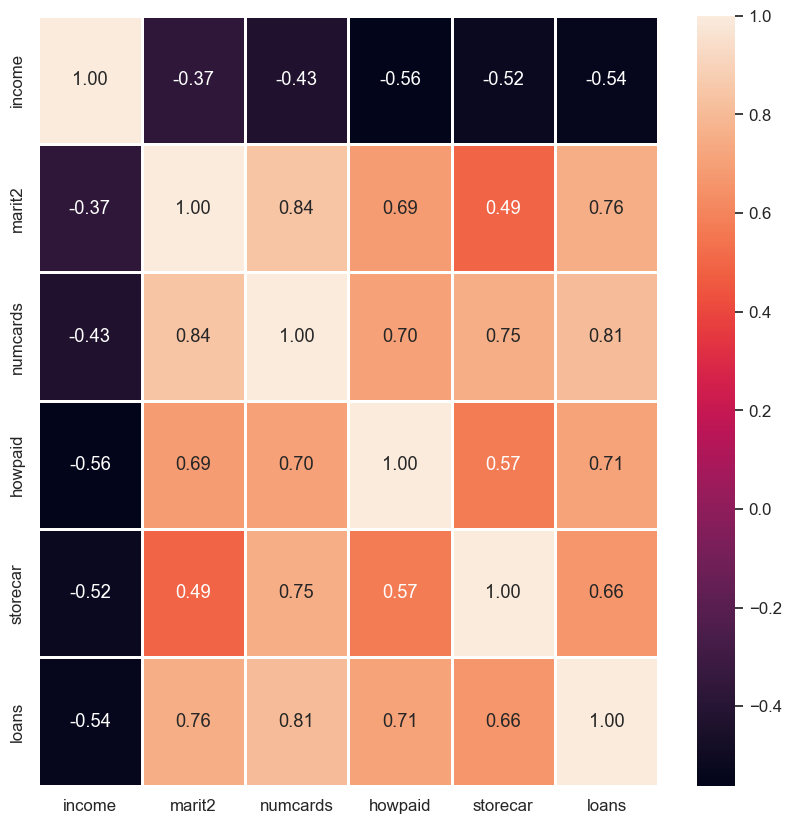

In [12]:
# and heatmap to show correlation between explanatory variables
from matplotlib import pyplot as plt        
import seaborn as sns                       

sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(X_train_stepwise.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

We have highly correlated variables and this is a problem if we want to interpret the coefficients of the regression. <br>
However, if we use the model only for prediction it is not that important <br>
In this example, we will skip the correction of the correlation and interpret the coefficients as if correlations were not high

In [13]:
X_train_stepwise = sm.add_constant(X_train_stepwise)

# statsmodels
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train_stepwise)
result=logit_model.fit_regularized()
print(result.summary2())

# print Exp(B) and confidence intervals
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['Lower', 'Upper', 'Odds Ratio']
print ("\nexp(B) & confidence intervals: ")
print (np.exp(conf))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5266690455635588
            Iterations: 39
            Function evaluations: 41
            Gradient evaluations: 39
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: risk             Pseudo R-squared: 0.233     
Date:               2025-02-05 10:51 AIC:              756.6034  
No. Observations:   705              BIC:              788.5107  
Df Model:           6                Log-Likelihood:   -371.30   
Df Residuals:       698              LL-Null:          -484.23   
Converged:          1.0000           LLR p-value:      5.8445e-46
No. Iterations:     39.0000          Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const          0.9798

In [19]:
cutoff = 0.5 # Every probability above 50% is considered a positive

train_preds = result.predict(X_train_stepwise)
train_preds_binary = (train_preds > cutoff).astype(int)  # Convert to binary labels (0 o 1)
train_conf_matrix = confusion_matrix(y_train, train_preds_binary)

train_conf_matrix_percentage = train_conf_matrix.astype('float') / train_conf_matrix.sum() * 100
train_conf_matrix_percentage = np.round(train_conf_matrix_percentage, 2)

print("Train dataset confusion matrix")
print(train_conf_matrix_percentage)

Train dataset confusion matrix
[[43.26 12.34]
 [13.19 31.21]]


In [17]:
X_test_stepwise = sm.add_constant(X_test_stepwise)

test_preds = result.predict(X_test_stepwise)
test_preds_binary = (test_preds > cutoff).astype(int)  

test_conf_matrix = confusion_matrix(y_test, test_preds_binary)
test_conf_matrix_percentage = test_conf_matrix.astype('float') / test_conf_matrix.sum() * 100
test_conf_matrix_percentage = np.round(test_conf_matrix_percentage, 2)

print(test_conf_matrix_percentage)

[[44.63 18.64]
 [13.56 23.16]]


### Calculates AUC, draws ROC and shows optimal threshold for accuracy

In [20]:
#defines the function to draw the curve with three parameters
def ROCCurve (df, target, txtdataset): #df is the data set, targ is 
    result = sm.Logit(target, df).fit()
    df['pred'] = result.predict(df)

    # AUC
    result = sm.Logit(target, df).fit()
    X_train_stepwise['pred'] = result.predict(df)
    fpr, tpr, thresholds =roc_curve(target, df['pred'])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)
    
    # Draws the roc curve
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots() 
    title='ROC curve for ' + txtdataset + " dataset"
    ax.set_title(title)
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.plot(fpr, tpr) #False Positive Rate(x axis) vs. True Positive Rate (y axis)
    ax.plot([0, 1], [0, 1], color="green")
    
    # Optimal cut-off
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'cut-off' : pd.Series(thresholds, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    print("Optimal cut-off for accuracy : " , list(roc_t['cut-off']))

Optimization terminated successfully.
         Current function value: 0.526669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525319
         Iterations 8
Area under the ROC curve : 0.802218
Optimal cut-off for accuracy :  [0.44801635883393615]


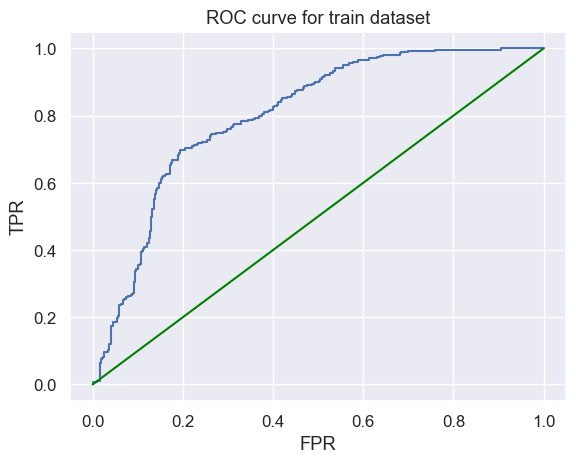

In [21]:
ROCCurve (X_train_stepwise, y_train, "train")

In [ ]:
# uncomment the following to display curve coordinates
# tpr, fpr, thresholds

Optimization terminated successfully.
         Current function value: 0.541034
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.530825
         Iterations 9
Area under the ROC curve : 0.755151
Optimal cut-off for accuracy :  [0.4068053533494265]


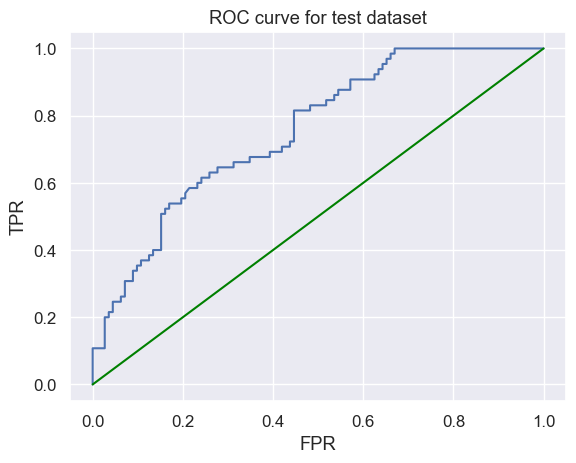

In [22]:
ROCCurve (X_test_stepwise, y_test, "test")